In [1]:
# Headers
import sys
sys.path.append("..")

import numpy as np
import pykssm
from matplotlib import rcParams
import matplotlib.pyplot as mtp

rcParams['axes.labelsize']   = 18
rcParams['xtick.labelsize']  = 18
rcParams['ytick.labelsize']  = 18
rcParams['legend.fontsize']  = 18
rcParams['axes.titlesize']   = 18
rcParams['axes.labelsize']   = 18
rcParams['font.family']      = 'sans-serif'
rcParams['font.serif']       = ['Computer Modern Roman']
rcParams['font.sans-serif']  = ['Helvetica']
rcParams['mathtext.fontset'] = 'stix'
rcParams['text.usetex']      = True

rcParams['lines.markeredgewidth'] = 1.5
rcParams['lines.linewidth']       = 1.5

# Offline Modelling

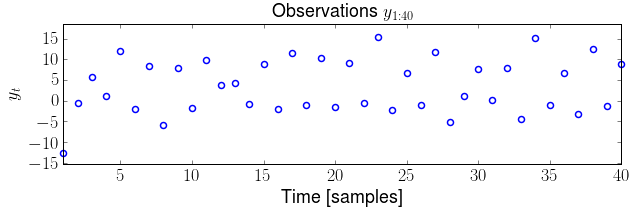

In [2]:
# Simple model
f  = lambda x: 10 * np.sinc(x / 7)
h  = lambda x: x
x0 = 0 + np.random.randn() * 10

sigmax = 2
sigmay = 2
size   = 40

(x, y) = pykssm.filter(f, h, sigmax, sigmay, x0, size)

# Let's see the data we'll be working with,
# the output of the filter
mtp.figure(figsize=(10, 2.5))
mtp.plot(list(range(1, size + 1)), y, "o", markerfacecolor="none", markeredgecolor="b", clip_on=False)
mtp.title("Observations $y_{1:" + str(size) + "}$")
mtp.xlabel("Time [samples]")
mtp.ylabel("$y_t$")
mtp.axis([1, size, 1.2 * np.min(y), 1.2 * np.max(y)])

mtp.show()

In [4]:
# KSSM, the core of this notebook
(samples, svectors, kernel) = pykssm.offline(observations = y[np.newaxis].T,
                                             hsensor      = lambda x, y: 0.5 / sigmay *
                                                                np.exp(-0.5 * (np.linalg.norm(x - y) / sigmay)**2),
                                             invhsensor   = lambda y: y,
                                             kernel       = pykssm.Kernel.GaussianKernel(),
                                             nsamples     = 400,
                                             snstd        = sigmax)

# kernel describes the used kernel reproducing hilbert space, with all parameters set (in this case sigma
# has been deduced from the data);
# svectors are the support vectors for the representation of the transition function, i.e. the components
# that will be mixed together to form a function;
# samples is a list of samples from the distribution p(f_t | y_{1:T}), where f_t is represented by a list {a_i}
# of mixing parameters that weight each support vector.
# So, each sampled transition function can be calculated using the expression
# f(x) = sum(a_i * kernel(svectors[i], x)).
# For this example, a gaussian kernel has been used (usually good for its universality properties),
# but it may be replaced with any other (and it's very simple to create new kernels).

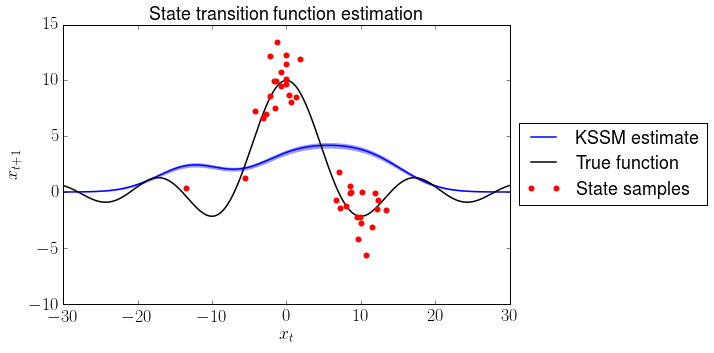

In [5]:
# State transition function estimation
limit = 10.0 * np.ceil(1/10.0 *2.0 * max(abs(min(x)), abs(max(x))))
grid  = np.arange(-limit, limit, 0.025)

# Discard the first 200 samples as the MCMC converges to the desired distribution
smean = np.mean(np.array(samples[20:]), 0)
svar  = np.var (np.array(samples[20:]), 0)

# Real transition function
real  = [f(i) for i in grid]

# Mean estimate and its marginal deviation (note that
# since support vectors are constants and the mixture
# is a linear combination, the variance just requires
# evaluating the mixture with the weight variances)
estmean = np.array([kernel.mixture_eval(smean, svectors, [i]) for i in grid])
estvar  = np.array([kernel.mixture_eval(svar,  svectors, [i]) for i in grid])
eststd  = np.sqrt(estvar)

mtp.figure(figsize = (8, 5))

mtp.fill_between(grid, estmean - eststd, estmean + eststd, color="b", alpha=0.4, linewidth=0.0)
mtp.plot(grid, estmean, "-b", label = "KSSM estimate")
mtp.plot(grid, real, "-k", label = "True function")

# Observed transitions
mtp.plot(x[:-1], x[1:], "or", clip_on=False, label="State samples", markeredgewidth=0.0)

mtp.legend(loc='center left', bbox_to_anchor=(1, 0.5))
mtp.title("State transition function estimation")
mtp.xlabel("$x_t$")
mtp.ylabel("$x_{t+1}$")

mtp.show()

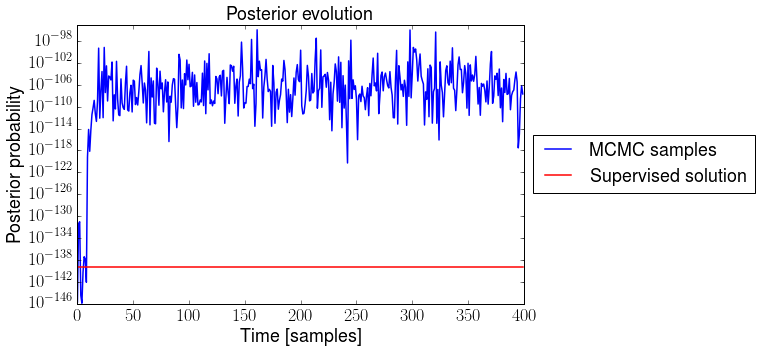

In [6]:
# Posterior evolution
like = []

for sample in samples:
    filter  = pykssm.SMC(observations = y[np.newaxis].T,
                         prior        = lambda: 0 + np.random.randn() * 10,
                         ftransition  = lambda x: kernel.mixture_eval(sample, svectors, x) + np.random.randn() * sigmax,
                         hsensor      = lambda x, y: 0.5/sigmay * np.exp(-((x - y)/sigmay)**2),
                         nsamples     = 50)
    
    like.append(filter.get_likelihood())

# Supervised alternative
supervisedf = pykssm.kls(x[:-1], x[1:], svectors, kernel)
sfilter = pykssm.SMC(observations = y[np.newaxis].T,
                     prior        = lambda: 0 + np.random.randn() * 10,
                     ftransition  = lambda x: kernel.mixture_eval(supervisedf, svectors, x) + np.random.randn() * sigmax,
                     hsensor      = lambda x, y: 0.5/sigmay * np.exp(-((x - y)/sigmay)**2),
                     nsamples     = 50)
supervisedlike = sfilter.get_likelihood() * np.ones(len(samples))

mtp.figure(figsize = (8, 5))

mtp.semilogy(like,           "-b", label="MCMC samples")
mtp.semilogy(supervisedlike, "-r", label="Supervised solution")

mtp.legend(loc='center left', bbox_to_anchor=(1, 0.5))
mtp.title("Posterior evolution")
mtp.xlabel("Time [samples]")
mtp.ylabel("Posterior probability")

mtp.show()

# Online Modelling

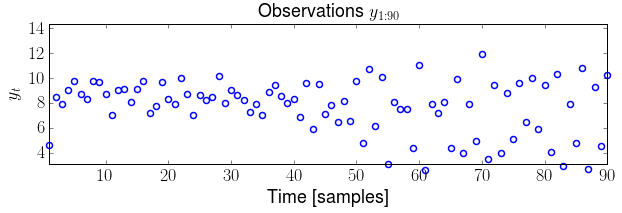

In [7]:
# Time-varying model
def ft(t, x):
    # time-invariant stable 
    def flow(x):
        return x / 2 + 25 * x / (1 + x * x)
    
    # time-invariant unstable (two accumulation points)
    def fhigh(x):
        return 10 * np.sinc(x / 7)
    
    # linear interpolation between the previous two
    def fmid(t, x):
        return (60 - t) / 30 * flow(x) + (t - 30) / 30 * fhigh(x)
    
    if t < 30:
        return flow(x)
    elif t > 60:
        return fhigh(x)
    else:
        return fmid(t, x)

h  = lambda x: x / 2 + 5
x0 = 0 + np.random.randn() * 1

sigmax = 1
sigmay = np.sqrt(0.5)
size   = 90

(x, y) = pykssm.filter_t(ft, h, sigmax, sigmay, x0, size)

# Output of the filter
mtp.figure(figsize=(10, 2.5))
mtp.plot(list(range(1, size + 1)), y, "o", markerfacecolor="none", markeredgecolor="b", clip_on=False)
mtp.title("Observations $y_{1:" + str(size) + "}$")
mtp.xlabel("Time [samples]")
mtp.ylabel("$y_t$")
mtp.axis([1, size, 1.2 * np.min(y), 1.2 * np.max(y)])

mtp.show()

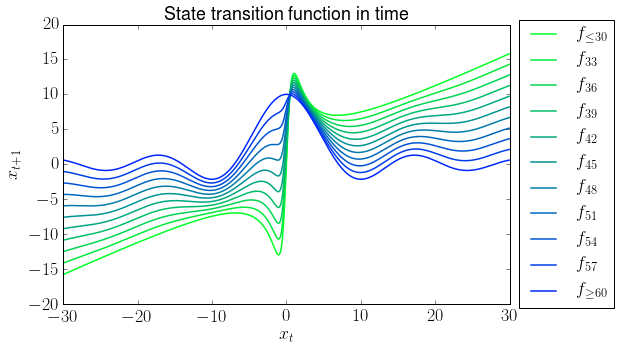

In [8]:
# Filter state transition function in time
limit = 10.0 * np.ceil(1/10.0 *2.0 * max(abs(min(x)), abs(max(x))))
grid  = np.arange(-limit, limit, 0.025)

mtp.figure(figsize=(8, 5))
for t in range(30, 61, 3):
    labelindex = str(t)
    
    if t == 30:
        labelindex = "\le 30"
    elif t == 60:
        labelindex = "\ge 60"
    
    mtp.plot(grid, [ft(t, i) for i in grid], "-",
             color=(0, 0.15 + 0.85 * (1 - (t - 30) / 30), 0.15 + 0.85 * (t - 30) / 30),
             label="$f_{" + labelindex + "}$")

mtp.legend(loc='center left', bbox_to_anchor=(1, 0.5))
mtp.title("State transition function in time")
mtp.xlabel("$x_t$")
mtp.ylabel("$x_{t+1}$")

mtp.show()

In [9]:
# Time-varying KSSM, the core of this notebook

# (state transition function) transition standard deviation
sigmaf = 0.2

estimate = pykssm.online(observations = y[np.newaxis].T,
                         hsensor      = lambda x, y: 0.5 / sigmay * np.exp(-0.5 * (np.linalg.norm(x - y)/sigmay)**2),
                         invhsensor   = lambda y: y,
                         theta        = lambda f1, f2: 0.5 / sigmaf * np.exp(-0.5 * (np.linalg.norm(f1 - f2)/sigmaf)**2),
                         kernel       = pykssm.Kernel.GaussianKernel(),
                         nsamples     = 400,
                         snstd        = sigmax)

# estimate is an array of tuples of the form (samples, svectors, kernel), each one corresponding
# to a time step and similar to the offline case.

/usr/local/lib/python3.4/dist-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/usr/local/lib/python3.4/dist-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.4/dist-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
../pykssm/MCMC.py:137: RuntimeWarning: invalid value encountered in double_scalars
  ratio = like / self._slike * self._hastingsfactor(proposal, self._sample)


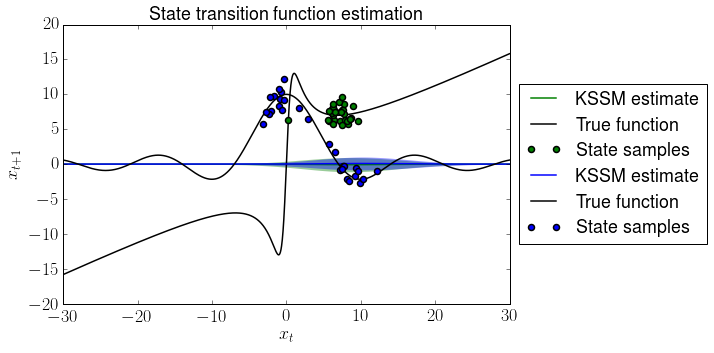

In [11]:
# Time-varying state transition function estimation
limit = 10.0 * np.ceil(1/10.0 *2.0 * max(abs(min(x)), abs(max(x))))
grid  = np.arange(-limit, limit, 0.025)

# We'll observe the estimate at two moments: 30 and 90 seconds,
# which are the end points for both time-invariant zones.
# The estimates' first index correspond to the samples, of which
# the first 200 are discarded while the MCMC converges to the desired distribution
smean30 = np.mean(np.array(estimate[30 - 1][0][20:]), 0)
svar30  = np.var (np.array(estimate[30 - 1][0][20:]), 0)

smean90 = np.mean(np.array(estimate[89 - 1][0][20:]), 0)
svar90  = np.var (np.array(estimate[89 - 1][0][20:]), 0)

# The estimates' second index correspond to the support vectors at that time
svectors30 = estimate[30 - 1][1]
svectors90 = estimate[89 - 1][1]

# Real transition functions
real30  = [ft(30, i) for i in grid]
real90  = [ft(89, i) for i in grid]

# Mean estimate and its marginal deviation
estmean30 = np.array([kernel.mixture_eval(smean30, svectors30, [i]) for i in grid])
estvar30  = np.array([kernel.mixture_eval(svar30,  svectors30, [i]) for i in grid])
eststd30  = np.sqrt(estvar30)
estmean90 = np.array([kernel.mixture_eval(smean90, svectors90, [i]) for i in grid])
estvar90  = np.array([kernel.mixture_eval(svar90,  svectors90, [i]) for i in grid])
eststd90  = np.sqrt(estvar90)

mtp.figure(figsize = (8, 5))

# First time-invariant zone estimate
mtp.fill_between(grid, estmean30 - eststd30, estmean30 + eststd30, color="g", alpha=0.4, linewidth=0.0)
mtp.plot(grid, estmean30, "-g", label = "KSSM estimate")
mtp.plot(grid, real30, "-k", label = "True function")
mtp.plot(x[0:30], x[1:31], "og", clip_on=False, label="State samples")

# Second time-invariant zone estimate
mtp.fill_between(grid, estmean90 - eststd90, estmean90 + eststd90, color="b", alpha=0.4, linewidth=0.0)
mtp.plot(grid, estmean90, "-b", label = "KSSM estimate")
mtp.plot(grid, real90, "-k", label = "True function")
mtp.plot(x[60:89], x[61:90], "ob", clip_on=False, label="State samples")

mtp.legend(loc='center left', bbox_to_anchor=(1, 0.5))
mtp.title("State transition function estimation")
mtp.xlabel("$x_t$")
mtp.ylabel("$x_{t+1}$")

mtp.show()

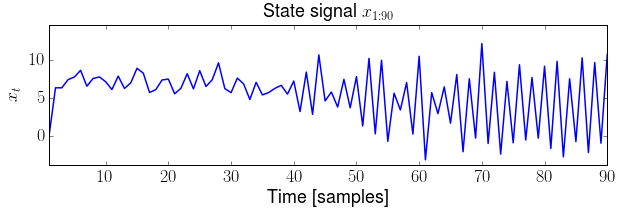

In [12]:
# Internal state of the filter
mtp.figure(figsize=(10, 2.5))
mtp.plot(list(range(1, size + 1)), x, "-b")
mtp.title("State signal $x_{1:" + str(size) + "}$")
mtp.xlabel("Time [samples]")
mtp.ylabel("$x_t$")
mtp.axis([1, size, 1.2 * np.min(x), 1.2 * np.max(x)])

mtp.show()